### Put all imports necessary here

In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from tqdm import tqdm
import matplotlib.pyplot as plt

### Load the Data

In [3]:
# Load the training data
train_file = np.load('train.npz')
train_data = train_file['data']
print("train_data's shape", train_data.shape)

# Load the testing data
test_file = np.load('test_input.npz')
test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


### Data Preprocessing

In [4]:
def prepare_data(data, is_train=True):
    """Extract ego vehicle's (agent 0) trajectories"""
    if is_train:
        X = data[:, 0, :50, :]  # (N, 50, 6) - First 50 timesteps
        Y = data[:, 0, 50:, :2]  # (N, 60, 2) - Next 60 (x,y)
    else:
        X = data[:, 0, :, :]  # (N, 50, 6) - Test uses only 50 timesteps
        Y = None
    return X, Y

X_train, Y_train = prepare_data(train_data)
X_test, _ = prepare_data(test_data, is_train=False)

# Normalize using training stats
pos_mean, pos_std = X_train[..., :2].mean(), X_train[..., :2].std()
X_train_norm = (X_train - pos_mean) / pos_std
Y_train_norm = (Y_train - pos_mean) / pos_std
X_test_norm = (X_test - pos_mean) / pos_std

# Convert to PyTorch tensors
train_dataset = TensorDataset(
    torch.FloatTensor(X_train_norm), 
    torch.FloatTensor(Y_train_norm)
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

### Define Models

In [5]:
class TrajectoryMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(50*6, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 60*2)  # Predict all 60 timesteps
        )
    
    def forward(self, x):
        x = self.flatten(x)
        return self.net(x).view(-1, 60, 2)  # Reshape to (batch, 60, 2)

model = TrajectoryMLP()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

### Do Training Loop

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(10):
    model.train()
    total_loss = 0
    for batch_X, batch_Y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Avg Loss: {total_loss/len(train_loader):.4f}")

Epoch 1: 100%|██████████| 157/157 [00:00<00:00, 203.60it/s]


Avg Loss: 0.0513


Epoch 2: 100%|██████████| 157/157 [00:00<00:00, 767.68it/s]


Avg Loss: 0.0054


Epoch 3: 100%|██████████| 157/157 [00:00<00:00, 799.45it/s]


Avg Loss: 0.0055


Epoch 4: 100%|██████████| 157/157 [00:00<00:00, 763.34it/s]


Avg Loss: 0.0049


Epoch 5: 100%|██████████| 157/157 [00:00<00:00, 842.81it/s]


Avg Loss: 0.0048


Epoch 6: 100%|██████████| 157/157 [00:00<00:00, 765.46it/s]


Avg Loss: 0.0042


Epoch 7: 100%|██████████| 157/157 [00:00<00:00, 770.90it/s]


Avg Loss: 0.0042


Epoch 8: 100%|██████████| 157/157 [00:00<00:00, 772.96it/s]


Avg Loss: 0.0051


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 773.60it/s]


Avg Loss: 0.0047


Epoch 10: 100%|██████████| 157/157 [00:00<00:00, 769.91it/s]

Avg Loss: 0.0043


100%|██████████| 1/1 [00:00<00:00, 121.97it/s]


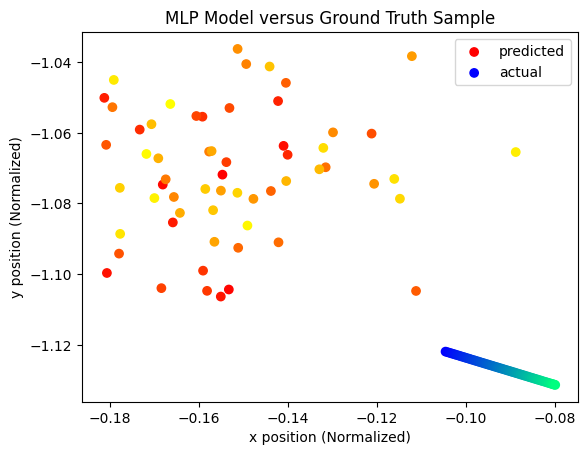

In [ ]:
import matplotlib.pyplot as plt

sampler = RandomSampler(train_dataset, replacement=True, num_samples=1)
train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=1)



for batch_X, batch_Y in tqdm(train_loader, total=len(train_loader)):
    batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
    outputs = model(batch_X)

    pred = outputs.cpu().detach().numpy()[0]
    actual = batch_Y.cpu().detach().numpy()[0]


    x_pred = pred[:, 0]
    y_pred = pred[:, 1]
    x_actual = actual[:, 0]
    y_actual = actual[:, 1]
    color = range(len(x_pred))

    plt.scatter(x_pred, y_pred, label="predicted", c=color, cmap = "autumn")
    plt.title("MLP Model versus Ground Truth Sample")
    plt.xlabel("x position (Normalized)")
    plt.ylabel("y position (Normalized)")
    plt.scatter(x_actual, y_actual, label="actual", c=color, cmap = "winter")
    plt.legend()






    
